# Modeling for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 데이터 설명
- Transfermarkt 웹사이트에서 스크레이핑한 각종 축구 데이터 (매주 한번 파일 업데이트)
    - 주요 대회 시즌별 60,000개 이상의 경기
    - 모든 대회의 400개 이상의 클럽들
    - 30,000 이상의 선수들
    - 400,000개 이상의 선수 가치 기록
    - 1,200,000개 이상의 선수 출전 기록

- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보

- 데이터베이스 스키마
    <img src="https://raw.githubusercontent.com/dcaribou/transfermarkt-datasets/master/resources/diagram.svg?sanitize=true" width="1700">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import RobustScaler

from xgboost import plot_importance

import warnings
warnings.filterwarnings(action='ignore')



c:\Users\aryij\anaconda3\envs\football\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 데이터 경로
path = "data/df_eda.csv"
df = pd.read_csv(path)

In [3]:
df.head()

,player_name,start_season,goals,assists,minutes_played,competition_code,date_of_birth,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
0,Aaron Connolly,2019,3,2,1261,premier-league,2000-01-28,20,Centre-Forward,Brighton and Hove Albion Football Club,4000000.0,Ireland,right,174.0
1,Aaron Connolly,2020,2,1,791,premier-league,2000-01-28,21,Centre-Forward,Brighton and Hove Albion Football Club,7000000.0,Ireland,right,174.0
2,Aaron Connolly,2021,0,0,155,premier-league,2000-01-28,22,Centre-Forward,Brighton and Hove Albion Football Club,6000000.0,Ireland,right,174.0
3,Aaron Cresswell,2019,3,0,2730,premier-league,1989-12-15,30,Left-Back,West Ham United Football Club,6500000.0,England,left,170.0
4,Aaron Cresswell,2020,0,8,3172,premier-league,1989-12-15,31,Left-Back,West Ham United Football Club,5000000.0,England,left,170.0


In [4]:
# date_of_birth 열 제거 (age로 대체)
df = df.drop("date_of_birth", axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              16001 non-null  object 
 1   start_season             16001 non-null  int64  
 2   goals                    16001 non-null  int64  
 3   assists                  16001 non-null  int64  
 4   minutes_played           16001 non-null  int64  
 5   competition_code         16001 non-null  object 
 6   age                      16001 non-null  int64  
 7   position                 16001 non-null  object 
 8   current_club_name        16001 non-null  object 
 9   market_value_per_season  16001 non-null  float64
 10  country                  16001 non-null  object 
 11  foot                     16001 non-null  object 
 12  height_in_cm             16001 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 1.6+ MB


In [6]:
# 수치형, 범주형 변수 따로 선언
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

In [7]:
print("수치형 변수 :", num_cols)
print("범주형 변수 :", cat_cols)

수치형 변수 : ['start_season', 'goals', 'assists', 'minutes_played', 'age', 'market_value_per_season', 'height_in_cm']
범주형 변수 : ['player_name', 'competition_code', 'position', 'current_club_name', 'country', 'foot']


## 데이터 분리

In [8]:
# target 컬럼 "market_value_per_season"
target = "market_value_per_season"
# 나머지 컬럼 features에 선언
features = df.drop(columns=target).columns

# 학습할 train 데이터 : 19-20 ~ 22-23 시즌 데이터 (4시즌)
train = df[df.start_season != 2023]
# 예측할 test 데이터 : 23-24 시즌 데이터
test = df[df.start_season == 2023]

train.shape, test.shape

((13081, 13), (2920, 13))

In [9]:
# validation 데이터셋 생성
train, val = train_test_split(train, train_size=0.8, random_state=42)

In [10]:
# train 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((10464, 12), (10464,), (2617, 12), (2617,), (2920, 12), (2920,))

In [11]:
num_cols = df.drop(columns=target).select_dtypes(include=np.number).columns.tolist()

# train 데이터 copy
X_train_no_enc = train[features].copy()
# y_train_no_enc = train[target].copy()

# validation 데이터 copy
X_val_no_enc = val[features].copy()
# y_val_no_enc = val[target].copy()

# test 데이터 copy
X_test_no_enc = test[features].copy()
# y_test_no_enc = test[target].copy()

## 인코딩

### Target Encoding
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [12]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[[cat_feature]] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[[cat_feature]] = te.transform(X_val[[cat_feature]])
    X_test[[cat_feature]] = te.transform(X_test[[cat_feature]])

## Baseline 모델 생성

In [13]:
# https://medium.com/machine-learning-with-python/multiple-linear-regression-implementation-in-python-2de9b303fc0c

In [14]:
# 선형회귀 모델로 Baseline 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
# Baseline 모델 절편, 결정 계수 확인

print("Intercept: ", lr.intercept_)
print("Coefficients:")
list(zip(X_train, lr.coef_))

Intercept:  339896027.3566966
Coefficients:


[('player_name', 0.6043258371837649),
 ('start_season', -169861.78878872033),
 ('goals', 704758.5701315616),
 ('assists', 587351.9735271847),
 ('minutes_played', 1802.571991680564),
 ('competition_code', 0.18366532093205024),
 ('age', -271814.1667087059),
 ('position', 0.10379805768661754),
 ('current_club_name', 0.39663096866570413),
 ('country', 0.023559503024443984),
 ('foot', -0.29803134123854136),
 ('height_in_cm', 30278.092645450604)]

In [16]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = model.predict(X_train)
    y_val_pred_lr = model.predict(X_val)
    y_test_pred_lr = model.predict(X_test)

    # Baseline 모델의 MAE, MSE, RMSE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr)
    # base_rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_lr))
    base_rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr, squared=False)


    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [17]:
baseline_model("Linear Regression", lr)


====== Baseline Model : Linear Regression ======


,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression,5377375.64,94223036260596.86,9706855.12,0.65


## 스케일링
- 데이터셋의 다양한 컬럼들에 이상치 다수 존재
    - 하지만 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라진다
    - 따라서 이상치 제거하지 않음
- `RobustScaler` 선택 (이상치의 영향 최소화)
- References
    - https://cheris8.github.io/data%20analysis/DP-Data-Scaling/

### `RobustScaling`
- 데이터의 중앙값 = 0, IQE = 1이 되도록 스케일링
    - IQR = Q3 - Q1 : 25퍼센타일과 75퍼센타일의 값들
- 중앙값 (Median)과 IQR (Interquartile Range) 사용
    - `RobustScaler`를 사용할 경우, `StandardScaler`에 비해 스케일링 결과가 더 넓게 분포
- 모든 feature들이 같은 스케일을 갖는다
- 이상치의 영향을 최소화 한다

In [18]:
# RobustScaler X_train 데이터셋에 fit
robustScaler = RobustScaler().fit(X_train)

# RobustScaler로 X_train, X_val, X_test 데이터셋 변환
X_train_robust = robustScaler.transform(X_train)
X_val_robust = robustScaler.transform(X_val)
X_test_robust = robustScaler.transform(X_test)

In [19]:
# num_cols = df.drop(columns=target).select_dtypes(include=np.number).columns.tolist()

# # catboost 사용하기 위한 scaling 따로 실시 (별도의 encoding 거치지 않고 스케일링)

# robustScaler_no_enc = RobustScaler().fit(X_train_no_enc[num_cols])

# # RobustScaler로 X_train_no_enc, X_val_no_enc, X_test_no_enc 데이터셋 변환
# X_train_robust_no_enc = robustScaler_no_enc.transform(X_train_no_enc[num_cols])
# X_val_robust_no_enc = robustScaler_no_enc.transform(X_val_no_enc[num_cols])
# X_test_robust_no_enc = robustScaler_no_enc.transform(X_test_no_enc[num_cols])

## 머신러닝 모델링

### 하이퍼 파라미터 튜닝 전 모델 생성

In [20]:
model_list = ["lr_model", "dt_model", "rf_model", "cat_model", "lgbm_model", "xgb_model"]

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

In [21]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

In [22]:
def model_list(models, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        model.fit(X_train_robust, y_train)

        # Robust Scaling 거친 train 데이터를 바탕으로 예측
        y_train_pred = model.predict(X_train_robust)
        y_val_pred = model.predict(X_val_robust)
        y_test_pred = model.predict(X_test_robust)

        # 모델의 MAE, MSE, RMSE, R2 score 확인
        meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
        meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
        # rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
        rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)


        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                                "MAE" : '{:.2f}'.format(meanAbErr),
                                "MSE" : '{:.2f}'.format(meanSqErr),
                                "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                "R2 Score" : '{:.2f}'.format(model.score(X_test_robust, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["R2 Score", "RMSE"], ascending=[False, True]).reset_index(drop=True)



In [23]:
# Top 3 : CatBoost, LightGBM, XGBoost순으로 R2 Score 높다
model_list(models)
    

Learning rate set to 0.059332
0:	learn: 13554768.3585355	total: 145ms	remaining: 2m 24s
1:	learn: 13082972.3704989	total: 148ms	remaining: 1m 13s
2:	learn: 12646354.8644727	total: 150ms	remaining: 49.9s
3:	learn: 12213743.6043951	total: 153ms	remaining: 38s
4:	learn: 11817248.7586241	total: 155ms	remaining: 30.9s
5:	learn: 11447804.1083780	total: 158ms	remaining: 26.2s
6:	learn: 11093960.9994336	total: 161ms	remaining: 22.8s
7:	learn: 10768863.4687689	total: 164ms	remaining: 20.3s
8:	learn: 10467536.2716959	total: 166ms	remaining: 18.3s
9:	learn: 10163328.8097091	total: 169ms	remaining: 16.8s
10:	learn: 9909528.8211220	total: 172ms	remaining: 15.5s
11:	learn: 9651966.4603719	total: 175ms	remaining: 14.4s
12:	learn: 9422248.2538975	total: 177ms	remaining: 13.5s
13:	learn: 9199086.1910990	total: 180ms	remaining: 12.7s
14:	learn: 8999180.2993393	total: 183ms	remaining: 12s
15:	learn: 8808157.7509272	total: 185ms	remaining: 11.4s
16:	learn: 8621612.4681208	total: 188ms	remaining: 10.9s
17:

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost,3930487.76,68240560999931.07,8260784.53,0.75
1,LightGBM,4025752.78,73530504243854.55,8574992.96,0.73
2,XGBoost,4236078.49,78758082800100.80,8874575.08,0.71
3,Random Forest,4239355.31,85567617923801.38,9250276.64,0.68
4,Linear Regression,5377375.64,94223036262991.84,9706855.12,0.65
5,Decision Tree,5428510.27,122546544948630.14,11070074.30,0.55


In [26]:
# 범주형 변수를 따로 Target Encoding 거치지 않은 데이터셋으로 학습한 CatBoost 확인
def model_list2(models):
    models_results = []

    for model_name, model in models:

        if model_name == "CatBoost":

            cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

            # 모델 생성 및 훈련
            model.fit(X_train_no_enc, y_train, cat_features=cat_features)

            # Robust Scaling 거치지 않은 train 데이터를 바탕으로 예측
            y_train_pred_cat = model.predict(X_train_no_enc)
            y_val_pred_cat = model.predict(X_val_no_enc)
            y_test_pred_cat = model.predict(X_test_no_enc)

            # 모델의 MAE, MSE, RMSE, R2 score 확인
            meanAbErr_cat = metrics.mean_absolute_error(y_test, y_test_pred_cat)
            meanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat)
            # rootMeanSqErr_cat = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_cat))
            rootMeanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat, squared=False)


            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr_cat),
                                    "MSE" : '{:.2f}'.format(meanSqErr_cat),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr_cat),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test_no_enc, y_test))})
        
        else:
            
            # 모델 생성 및 훈련
            model.fit(X_train, y_train)

            # Robust Scaling 거친 train 데이터를 바탕으로 예측
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            y_test_pred = model.predict(X_test)

            # 모델의 MAE, MSE, RMSE, R2 score 확인
            meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
            meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
            # rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
            rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)


            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr),
                                    "MSE" : '{:.2f}'.format(meanSqErr),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models before Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["R2 Score", "RMSE"], ascending=[False, True]).reset_index(drop=True)

In [27]:
model_list2(models[3:])

Learning rate set to 0.059332
0:	learn: 13653696.6051392	total: 63.5ms	remaining: 1m 3s
1:	learn: 13289911.9578542	total: 145ms	remaining: 1m 12s
2:	learn: 12974497.2540124	total: 230ms	remaining: 1m 16s
3:	learn: 12664524.7075041	total: 337ms	remaining: 1m 23s
4:	learn: 12381771.8118006	total: 411ms	remaining: 1m 21s
5:	learn: 12110808.3301324	total: 487ms	remaining: 1m 20s
6:	learn: 11857426.9500235	total: 562ms	remaining: 1m 19s
7:	learn: 11614183.0093664	total: 639ms	remaining: 1m 19s
8:	learn: 11410700.5592546	total: 716ms	remaining: 1m 18s
9:	learn: 11187253.5307023	total: 791ms	remaining: 1m 18s
10:	learn: 10977126.3796601	total: 864ms	remaining: 1m 17s
11:	learn: 10794053.4259314	total: 995ms	remaining: 1m 21s
12:	learn: 10632607.2516437	total: 1.12s	remaining: 1m 25s


13:	learn: 10463427.2507392	total: 1.24s	remaining: 1m 27s
14:	learn: 10314079.3497962	total: 1.33s	remaining: 1m 27s
15:	learn: 10166125.8591156	total: 1.41s	remaining: 1m 26s
16:	learn: 10041279.0114318	total: 1.51s	remaining: 1m 27s
17:	learn: 9913880.9363225	total: 1.58s	remaining: 1m 26s
18:	learn: 9807153.9831189	total: 1.67s	remaining: 1m 26s
19:	learn: 9686940.5559453	total: 1.74s	remaining: 1m 25s
20:	learn: 9566429.5967320	total: 1.81s	remaining: 1m 24s
21:	learn: 9474636.1701422	total: 1.88s	remaining: 1m 23s
22:	learn: 9398267.8959780	total: 1.95s	remaining: 1m 22s
23:	learn: 9316464.7605659	total: 2.02s	remaining: 1m 22s
24:	learn: 9233534.7495638	total: 2.1s	remaining: 1m 21s
25:	learn: 9136735.8515042	total: 2.18s	remaining: 1m 21s
26:	learn: 9054682.5801244	total: 2.25s	remaining: 1m 21s
27:	learn: 8991102.7377345	total: 2.33s	remaining: 1m 20s
28:	learn: 8947734.3551949	total: 2.4s	remaining: 1m 20s
29:	learn: 8889333.9577482	total: 2.47s	remaining: 1m 20s
30:	learn: 8

,Model,MAE,MSE,RMSE,R2 Score
0,LightGBM,4008658.86,72529401676676.06,8516419.53,0.73
1,XGBoost,4235432.04,78686850833874.16,8870560.91,0.71
2,CatBoost,4599038.41,85747317567412.42,9259984.75,0.68


#### `CatBoost` 성능 비교
- 별도로 `Target Encoding` 거친 데이터셋으로 진행(`model_list` 함수)한 `CatBoost`가 더 높은 `R2 Score` 기록

    - **0.75 vs 0.68** (Target Encoding 실행한 데이터셋으로 진행)

### 하이퍼 파라미터 튜닝
- R2 Score가 높은 `CatBoost`, `LightGBM`, `XGBoost` 을 갖고 하이퍼 파라미터 튜닝
    - Baseline 모델인 `Linear Regression`의 R2 Score보다 높다 (0.65)

- `optuna` 활용
    - References : https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/


#### `CatBoost`

In [28]:
def objective_cat(trial):
    params = {
        # "iterations": 1000,
        "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True, random_state=42)
    model.fit(X_train_robust, y_train)
    # predictions = model.predict(X_val_robust)
    # rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
    predictions = model.predict(X_val_robust)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
    return rmse

In [29]:
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=30)

[I 2024-04-03 04:32:37,797] A new study created in memory with name: no-name-66bd5177-d8fd-42a6-9226-e4b826ff2ac1
[I 2024-04-03 04:32:47,040] Trial 0 finished with value: 7549640.390418803 and parameters: {'n_estimators': 2855, 'learning_rate': 0.001346666568224916, 'depth': 6, 'subsample': 0.9992844357270285, 'colsample_bylevel': 0.76449839167017, 'min_data_in_leaf': 47}. Best is trial 0 with value: 7549640.390418803.


[I 2024-04-03 04:33:10,077] Trial 1 finished with value: 7339388.536946066 and parameters: {'n_estimators': 2551, 'learning_rate': 0.0029807133167513793, 'depth': 9, 'subsample': 0.9651727767628591, 'colsample_bylevel': 0.8927386695580386, 'min_data_in_leaf': 22}. Best is trial 1 with value: 7339388.536946066.
[I 2024-04-03 04:33:11,984] Trial 2 finished with value: 8157005.381877246 and parameters: {'n_estimators': 1838, 'learning_rate': 0.02061029358346323, 'depth': 1, 'subsample': 0.3022667246407474, 'colsample_bylevel': 0.7225550792751142, 'min_data_in_leaf': 36}. Best is trial 1 with value: 7339388.536946066.
[I 2024-04-03 04:33:14,931] Trial 3 finished with value: 7592612.05568709 and parameters: {'n_estimators': 1504, 'learning_rate': 0.002886708696494447, 'depth': 5, 'subsample': 0.1511996578613365, 'colsample_bylevel': 0.44387814777768814, 'min_data_in_leaf': 3}. Best is trial 1 with value: 7339388.536946066.
[I 2024-04-03 04:33:21,877] Trial 4 finished with value: 6797558.042

In [30]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 1872, 'learning_rate': 0.04140985840795572, 'depth': 7, 'subsample': 0.8186009204009024, 'colsample_bylevel': 0.3073648261405851, 'min_data_in_leaf': 34}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
6778544.6461265795


In [31]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [32]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [33]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
model_list([("CatBoost", cat_optuna)])

0:	learn: 13726354.4682013	total: 2.69ms	remaining: 5.03s
1:	learn: 13399895.4563349	total: 9.41ms	remaining: 8.8s
2:	learn: 13047614.8783801	total: 14.6ms	remaining: 9.07s
3:	learn: 12728499.1194970	total: 19.8ms	remaining: 9.24s
4:	learn: 12427339.0973939	total: 23.3ms	remaining: 8.71s
5:	learn: 12144058.8521506	total: 26.5ms	remaining: 8.24s
6:	learn: 11859189.3109110	total: 30ms	remaining: 8s
7:	learn: 11672757.8332124	total: 33.1ms	remaining: 7.71s
8:	learn: 11417341.9976033	total: 36.8ms	remaining: 7.62s
9:	learn: 11170474.3419462	total: 40.1ms	remaining: 7.47s
10:	learn: 10942700.5350054	total: 44.2ms	remaining: 7.48s
11:	learn: 10753927.5549190	total: 46.7ms	remaining: 7.24s
12:	learn: 10548711.2495453	total: 50.2ms	remaining: 7.18s
13:	learn: 10361392.7485180	total: 54.7ms	remaining: 7.26s
14:	learn: 10361376.0195642	total: 56.1ms	remaining: 6.94s
15:	learn: 10180768.1838345	total: 59.4ms	remaining: 6.89s
16:	learn: 9992444.9355983	total: 63.3ms	remaining: 6.91s
17:	learn: 980

1600:	learn: 2851800.3802741	total: 5.49s	remaining: 929ms
1601:	learn: 2850894.3167153	total: 5.49s	remaining: 925ms
1602:	learn: 2850020.3544552	total: 5.49s	remaining: 922ms
1603:	learn: 2848870.6000408	total: 5.5s	remaining: 918ms
1604:	learn: 2847775.3361127	total: 5.5s	remaining: 915ms
1605:	learn: 2846905.2663701	total: 5.5s	remaining: 911ms
1606:	learn: 2845921.4825636	total: 5.51s	remaining: 908ms
1607:	learn: 2845735.0600327	total: 5.51s	remaining: 905ms
1608:	learn: 2845576.1931495	total: 5.51s	remaining: 901ms
1609:	learn: 2844216.3022325	total: 5.52s	remaining: 898ms
1610:	learn: 2843666.3920806	total: 5.52s	remaining: 895ms
1611:	learn: 2842779.0964012	total: 5.53s	remaining: 892ms
1612:	learn: 2842130.7978616	total: 5.53s	remaining: 888ms
1613:	learn: 2841218.2193346	total: 5.53s	remaining: 885ms
1614:	learn: 2839727.7379926	total: 5.54s	remaining: 881ms
1615:	learn: 2838421.1840211	total: 5.54s	remaining: 878ms
1616:	learn: 2836881.4660147	total: 5.55s	remaining: 875ms


,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost,3955032.29,69755133701633.05,8351953.89,0.74


#### `XGBoost`

In [34]:
def objective_xgb(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        # "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        # "max_depth": trial.suggest_int("max_depth", 8, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train_robust, y_train, verbose=False)
    predictions = model.predict(X_val_robust)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
    return rmse

In [35]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)

[I 2024-04-03 04:36:07,585] A new study created in memory with name: no-name-10eda127-329a-4080-af05-c2fa8933fac1
[I 2024-04-03 04:36:15,220] Trial 0 finished with value: 7678054.515446181 and parameters: {'n_estimators': 1147, 'learning_rate': 0.0021221022476808488, 'max_depth': 9, 'subsample': 0.7118164076353071, 'colsample_bytree': 0.9508334296047407, 'min_child_weight': 19}. Best is trial 0 with value: 7678054.515446181.
[I 2024-04-03 04:36:26,285] Trial 1 finished with value: 7940081.601184802 and parameters: {'n_estimators': 1894, 'learning_rate': 0.0010582460453960687, 'max_depth': 9, 'subsample': 0.6446477836267541, 'colsample_bytree': 0.8573124688453988, 'min_child_weight': 12}. Best is trial 0 with value: 7678054.515446181.
[I 2024-04-03 04:36:29,524] Trial 2 finished with value: 9810454.95824734 and parameters: {'n_estimators': 1493, 'learning_rate': 0.0033992281819492766, 'max_depth': 9, 'subsample': 0.9459171909969176, 'colsample_bytree': 0.13228816428955092, 'min_child_we

In [36]:
print("Best hyperparameters:", study_xgb.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_xgb.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 2146, 'learning_rate': 0.03562311760355619, 'max_depth': 7, 'subsample': 0.539838018576136, 'colsample_bytree': 0.8057658407580487, 'min_child_weight': 10}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
6769882.299083187


In [37]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_xgb)

In [38]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_xgb)

In [39]:
xgb_optuna = XGBRegressor(**study_xgb.best_params)
model_list([("XGBoost", xgb_optuna)])


====== Models Before Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,R2 Score
0,XGBoost,4127691.23,72459221162346.50,8512298.23,0.73


#### `LightGBM`

In [40]:
def objective_lgbm(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        # "n_estimators": 1000,
        "n_estimators": trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train_robust, y_train)
    predictions = model.predict(X_val_robust)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
    return rmse

In [41]:
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-04-03 04:39:22,468] A new study created in memory with name: no-name-2338112f-2985-4e11-8971-96831bc95b4d


[I 2024-04-03 04:39:26,844] Trial 0 finished with value: 7348050.531425289 and parameters: {'n_estimators': 3922, 'learning_rate': 0.0011888503267555198, 'num_leaves': 35, 'subsample': 0.9709967389158229, 'colsample_bytree': 0.5491553188025694, 'min_data_in_leaf': 57}. Best is trial 0 with value: 7348050.531425289.
[I 2024-04-03 04:39:31,361] Trial 1 finished with value: 7644302.95375506 and parameters: {'n_estimators': 2100, 'learning_rate': 0.0018122261827673508, 'num_leaves': 840, 'subsample': 0.855567358373922, 'colsample_bytree': 0.64219139298008, 'min_data_in_leaf': 89}. Best is trial 0 with value: 7348050.531425289.
[I 2024-04-03 04:39:37,128] Trial 2 finished with value: 7451681.228184385 and parameters: {'n_estimators': 3536, 'learning_rate': 0.061550142381094027, 'num_leaves': 545, 'subsample': 0.15741978180904015, 'colsample_bytree': 0.9781462120896588, 'min_data_in_leaf': 22}. Best is trial 0 with value: 7348050.531425289.
[I 2024-04-03 04:39:45,090] Trial 3 finished with v

In [42]:
print("Best hyperparameters:", study_lgbm.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_lgbm.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 1852, 'learning_rate': 0.016600103980822907, 'num_leaves': 687, 'subsample': 0.7101398093998572, 'colsample_bytree': 0.763690123186821, 'min_data_in_leaf': 12}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
6807550.795233552


In [43]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_lgbm)

In [44]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_lgbm)

In [45]:
lgbm_optuna = LGBMRegressor(**study_lgbm.best_params)
model_list([("LightGBM", lgbm_optuna)])

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 10464, number of used features: 12
[LightGBM] [Info] Start training from score 8983092.029817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,Model,MAE,MSE,RMSE,R2 Score
0,LightGBM,4035029.41,76735877245812.59,8759901.67,0.72


#### 튜닝한 모델들 비교

In [46]:
models_tuned = models = [
    ("CatBoost", cat_optuna),
    ("LightGBM", lgbm_optuna),
    ("XGBoost", xgb_optuna)
]

In [47]:
model_list(models_tuned, "After")

0:	learn: 13726354.4682013	total: 2.35ms	remaining: 4.39s
1:	learn: 13399895.4563349	total: 5.31ms	remaining: 4.96s
2:	learn: 13047614.8783801	total: 9.09ms	remaining: 5.66s
3:	learn: 12728499.1194970	total: 13.9ms	remaining: 6.5s
4:	learn: 12427339.0973939	total: 17.4ms	remaining: 6.48s
5:	learn: 12144058.8521506	total: 20.7ms	remaining: 6.44s
6:	learn: 11859189.3109110	total: 24.7ms	remaining: 6.59s
7:	learn: 11672757.8332124	total: 27.9ms	remaining: 6.51s
8:	learn: 11417341.9976033	total: 31.2ms	remaining: 6.45s
9:	learn: 11170474.3419462	total: 34.1ms	remaining: 6.35s
10:	learn: 10942700.5350054	total: 37.4ms	remaining: 6.32s
11:	learn: 10753927.5549190	total: 39.9ms	remaining: 6.18s
12:	learn: 10548711.2495453	total: 43.4ms	remaining: 6.21s
13:	learn: 10361392.7485180	total: 47.1ms	remaining: 6.25s
14:	learn: 10361376.0195642	total: 48.3ms	remaining: 5.98s
15:	learn: 10180768.1838345	total: 51ms	remaining: 5.92s
16:	learn: 9992444.9355983	total: 54.7ms	remaining: 5.97s
17:	learn: 

1023:	learn: 3447211.2832642	total: 3.45s	remaining: 2.85s
1024:	learn: 3445788.0953953	total: 3.45s	remaining: 2.85s
1025:	learn: 3444141.6010475	total: 3.45s	remaining: 2.85s
1026:	learn: 3442060.3115173	total: 3.46s	remaining: 2.85s
1027:	learn: 3441047.5314088	total: 3.46s	remaining: 2.84s
1028:	learn: 3439760.4584438	total: 3.47s	remaining: 2.84s
1029:	learn: 3439248.7744498	total: 3.47s	remaining: 2.84s
1030:	learn: 3438100.5564363	total: 3.47s	remaining: 2.83s
1031:	learn: 3436850.9566211	total: 3.48s	remaining: 2.83s
1032:	learn: 3435720.4443710	total: 3.48s	remaining: 2.83s
1033:	learn: 3434213.9769742	total: 3.48s	remaining: 2.82s
1034:	learn: 3432481.8832340	total: 3.49s	remaining: 2.82s
1035:	learn: 3431353.6263936	total: 3.49s	remaining: 2.82s
1036:	learn: 3429783.7378920	total: 3.5s	remaining: 2.82s
1037:	learn: 3428461.3048542	total: 3.5s	remaining: 2.81s
1038:	learn: 3427435.0628808	total: 3.5s	remaining: 2.81s
1039:	learn: 3426669.6026166	total: 3.51s	remaining: 2.81s


,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost,3955032.29,69755133701633.05,8351953.89,0.74
1,XGBoost,4127691.23,72459221162346.50,8512298.23,0.73
2,LightGBM,4035029.41,76735877245812.59,8759901.67,0.72


In [ ]:
# XGBoost 모델 생성
model_xgb = XGBRegressor(n_estimators=1000,
                          learning_rate=0.2,
                          min_child_weight=100,
                          max_depth=3,
                          gamma=100,
                          colsample_bytree=0.5,
                          random_state=42)

# Robust 스케일링 적용한 X_train_scaled 이용
model_xgb.fit(X_train_robust, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=100, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=100, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

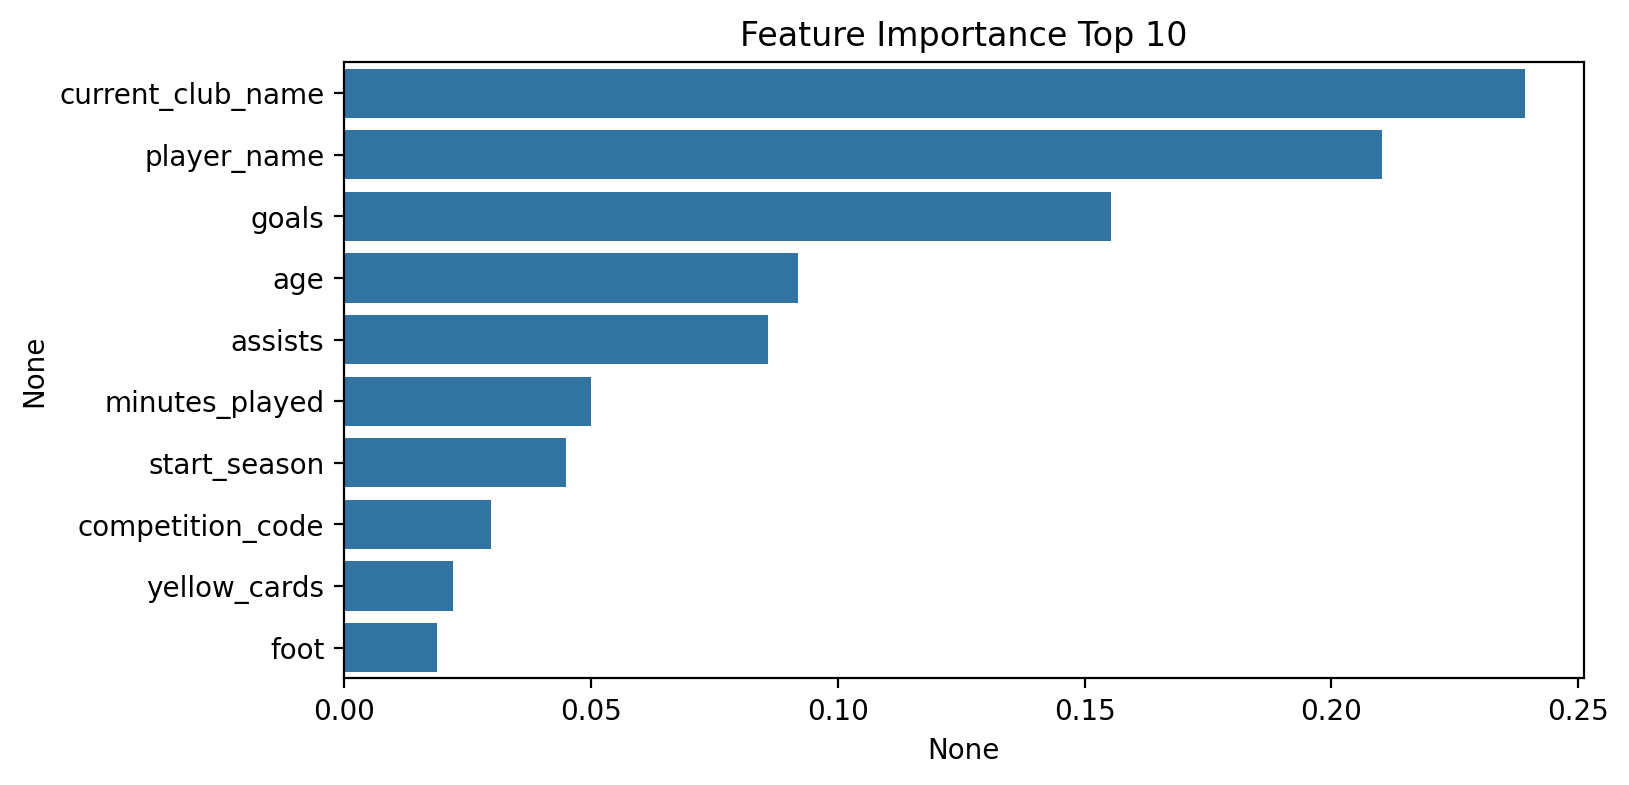

In [ ]:
# feature importance 파악

# 배열형태로 반환
xgb_importance_values = model_xgb.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
xgb_series = pd.Series(xgb_importance_values, index = X_train.columns)
xgb_top10 = xgb_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=xgb_top10, y=xgb_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [ ]:
model_xgb.score(X_train_robust, y_train)

0.9011207493784258

In [ ]:
model_xgb.score(X_val_robust, y_val)

0.7582968045697435

In [ ]:
model_xgb.score(X_test_robust, y_test)

0.7313182384067913

In [ ]:
model_xgb.predict(X_test_robust)

array([-1335389.5 , 16928328.  , 16992832.  , ...,   177909.81,
        -317619.7 , 26650216.  ], dtype=float32)

In [ ]:
metrics.mean_squared_error(y_test, model_xgb.predict(X_test_robust), squared=False)

8536613.855522411

In [ ]:
# 1446
# Kai Havertz
model_xgb.predict(X_test_robust)[1446]

70182990.0

In [ ]:
y_test

7          900000.0
11       30000000.0
21       28000000.0
26       15000000.0
27         500000.0
            ...    
15983     5000000.0
15988     1800000.0
15994     1000000.0
15995     1000000.0
16000    18000000.0
Name: market_value_per_season, Length: 2920, dtype: float64

In [ ]:
X_test

,player_name,start_season,yellow_cards,red_cards,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7,3.090621e+06,2023,1,0,0,0,235,1.760686e+07,34,7.573533e+06,1.669718e+07,1.580558e+07,9.059222e+06,170.0
11,1.378455e+07,2023,5,0,0,0,720,1.760686e+07,21,6.410489e+06,1.246267e+07,1.165922e+07,8.371419e+06,185.0
21,1.869467e+07,2023,0,0,0,0,540,1.760686e+07,25,5.777534e+06,3.253681e+07,1.580558e+07,8.982164e+06,190.0
26,6.612677e+06,2023,1,0,0,0,526,1.760686e+07,21,1.040246e+07,4.469679e+06,1.580558e+07,8.982164e+06,181.0
27,8.983092e+06,2023,1,0,1,0,298,9.004052e+06,28,9.240542e+06,1.740985e+06,8.238751e+06,9.059222e+06,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15983,4.012582e+06,2023,4,0,1,0,2093,9.404664e+06,29,9.814288e+06,3.976935e+06,7.964127e+06,8.982164e+06,177.0
15988,2.202918e+06,2023,4,0,1,4,1664,9.404664e+06,34,6.410489e+06,8.704671e+06,7.964127e+06,8.982164e+06,182.0
15994,9.018411e+05,2023,0,0,0,0,1170,9.404664e+06,33,5.777534e+06,1.168214e+07,1.263018e+07,8.982164e+06,192.0
15995,8.983092e+06,2023,1,0,1,0,366,2.712768e+06,22,1.059005e+07,9.386958e+05,6.922201e+06,9.059222e+06,170.0


In [ ]:
y_test[y_test == 55000000.0]

1760     55000000.0
3380     55000000.0
7842     55000000.0
8596     55000000.0
8752     55000000.0
9670     55000000.0
10023    55000000.0
10024    55000000.0
14431    55000000.0
15091    55000000.0
Name: market_value_per_season, dtype: float64

In [ ]:
y_test.reset_index()

,index,market_value_per_season
0,7,900000.0
1,11,30000000.0
2,21,28000000.0
3,26,15000000.0
4,27,500000.0
...,...,...
2915,15983,5000000.0
2916,15988,1800000.0
2917,15994,1000000.0
2918,15995,1000000.0


In [ ]:
y_test.reset_index()[y_test.reset_index()["index"]==7842]

,index,market_value_per_season
1446,7842,55000000.0


In [ ]:
df[df.player_name=="Kai Havertz"]

,player_name,start_season,yellow_cards,red_cards,goals,assists,minutes_played,competition_code,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
7838,Kai Havertz,2019,3,0,12,6,2463,bundesliga,20,Attacking Midfield,Arsenal Football Club,81000000.0,Germany,left,193.0
7839,Kai Havertz,2020,2,0,4,5,1520,premier-league,21,Attacking Midfield,Arsenal Football Club,70000000.0,Germany,left,193.0
7840,Kai Havertz,2021,3,0,8,4,1811,premier-league,22,Attacking Midfield,Arsenal Football Club,70000000.0,Germany,left,193.0
7841,Kai Havertz,2022,5,0,7,1,2579,premier-league,23,Attacking Midfield,Arsenal Football Club,55000000.0,Germany,left,193.0
7842,Kai Havertz,2023,7,0,8,3,1783,premier-league,24,Attacking Midfield,Arsenal Football Club,55000000.0,Germany,left,193.0


In [ ]:
test[features][test[features].player_name=="Kai Havertz"]

,player_name,start_season,yellow_cards,red_cards,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7842,Kai Havertz,2023,7,0,8,3,1783,premier-league,24,Attacking Midfield,Arsenal Football Club,Germany,left,193.0
